In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random


C:\Users\Rock_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [3]:
#dataset = "../../Pics/cleaned1"
#dataset = "../../Pics/mirrored1"
#dataset = "../../Pics/tagged2"
#dataset = "../../Pics/mirrored2"
#dataset = "../../Pics/testTrack"

dataset = "../../Pics/Track/OldDataset_balanced"
#dataset = "../../Pics/Track/Datasets_Axionable/ironcar_pics"
#dataset = "../../Pics/Track/Mixed"

#dataset = "../../Pics/BigOne"


In [4]:
# load images from both train and test groups
directory = '../../' + dataset
images, labels_speed, labels_dir = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels: %d' % nb_images)

Loaded Images and labels: 1699


In [5]:
#Normalise images
images = np.array(images)
images /= 255

In [6]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))

(array([0, 1], dtype=uint8),
 array([0, 0, 1, 0, 0], dtype=uint8),
 <matplotlib.image.AxesImage at 0x19e42c957b8>)

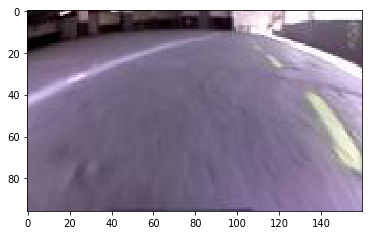

In [7]:
labels_speed[42], labels_dir[42], plt.imshow(images[42])

In [8]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers

In [9]:
K.clear_session()
############################################################# Multitask Model 1

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(2, (6,4), strides=(2,2), activation='relu')(x)
x = Convolution2D(4, (4,2), strides=(2,1), activation='relu')(x)
x = BatchNormalization()(x)

flat = Flatten()(x)

x = Dense(8)(flat)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

out_speed = Dense(2, activation='softmax')(x)
out_dir = Dense(5, activation='softmax')(x)

model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 96, 160, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 79, 2)    146         img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 78, 4)    68          conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 22, 78, 4)    16          conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [74]:
K.clear_session()
############################################################# Multitask Model 2

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(8, (8,4), strides=(4,4), activation='relu')(x)
x = Convolution2D(8, (4,2), strides=(4,4), activation='relu')(x)
x = Convolution2D(8, (2,1), strides=(2,2), activation='relu')(x)
x = Convolution2D(8, (1,1), strides=(1,1), activation='relu')(x)

x = BatchNormalization()(x)

x = Flatten()(x)

#x = Dense(100, activation='relu')(x)
#x = Dropout(0.4)(x)
#x = Dense(80, activation='relu')(x)
#x = Dropout(0.4)(x)

out_speed = Dense(2, activation='softmax')(x)
out_dir = Dense(5, activation='softmax')(x)

model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 96, 160, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 23, 40, 8)    776         img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 5, 10, 8)     520         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 2, 5, 8)      136         conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [76]:
h = model.fit(images, [labels_speed, labels_dir], batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Train on 1189 samples, validate on 510 samples
Epoch 1/20
1189/1189 [==============================] - 1s 907us/step - loss: 1.3219 - dense_1_loss: 0.3601 - dense_2_loss: 0.9618 - dense_1_acc: 0.8495 - dense_2_acc: 0.6434 - val_loss: 2.3400 - val_dense_1_loss: 0.8769 - val_dense_2_loss: 1.4632 - val_dense_1_acc: 0.5980 - val_dense_2_acc: 0.5020
Epoch 2/20
1189/1189 [==============================] - 1s 873us/step - loss: 1.3083 - dense_1_loss: 0.3571 - dense_2_loss: 0.9512 - dense_1_acc: 0.8469 - dense_2_acc: 0.6484 - val_loss: 1.6964 - val_dense_1_loss: 0.6783 - val_dense_2_loss: 1.0181 - val_dense_1_acc: 0.6961 - val_dense_2_acc: 0.6137
Epoch 3/20
1189/1189 [==============================] - 1s 942us/step - loss: 1.3243 - dense_1_loss: 0.3666 - dense_2_loss: 0.9577 - dense_1_acc: 0.8419 - dense_2_acc: 0.6451 - val_loss: 1.3773 - val_dense_1_loss: 0.3989 - val_dense_2_loss: 0.9783 - val_dense_1_acc: 0.8216 - val_dense_2_acc: 0.6216
Epoch 4/20
1189/1189 [==============================]

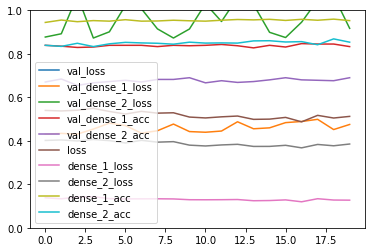

In [36]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [136]:
model.save('model_multi_.h5')

In [55]:
#######################  VALIDATION

#dataset = "../../Pics/cleaned1"
#dataset = "../../Pics/mirrored1"
#dataset = "../../Pics/tagged2"
#dataset = "../../Pics/mirrored2"
#dataset = "../../Pics/testTrack"

dataset = "../../Pics/Track/OldDataset_balanced"
#dataset = "../../Pics/Track/Datasets_Axionable/ironcar_pics"
#dataset = "../../Pics/Track/Mixed"

In [56]:
def load_photos_val(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [57]:
# load images from both train and test groups
directory = '../../' + dataset
images_val, labels_speed_val, labels_dir_val = load_photos(directory)
nb_images = len(images_val)
print('Loaded Images and labels: %d' % nb_images)

Loaded Images and labels: 1699


In [58]:
images_val = np.array(images_val)
images_val /= 255

In [59]:
# Get predictions
all_preds = model.predict(images_val)

speed_preds = []
for elem in all_preds[0]:
    speed_preds.append(np.argmax(elem))
    
dir_preds = []
for elem in all_preds[1]:
    dir_preds.append(np.argmax(elem))

In [60]:
res = 0
for i, value in enumerate(speed_preds):
    if value != labels_speed_val[i]:
        res += 1
print("error_rate = " + str(res/i))

error_rate = 0.09599528857479388


In [61]:
res = 0

i_0 = 0
res_0 = 0
res_0_1 = 0
res_0_2 = 0
res_0_3 = 0
res_0_4 = 0

i_1 = 0
res_1 = 0
res_1_1 = 0
res_1_2 = 0
res_1_3 = 0

i_2 = 0
res_2 = 0
res_2_1 = 0
res_2_2 = 0

i_3 = 0
res_3 = 0
res_3_1 = 0
res_3_2 = 0
res_3_3 = 0

i_4 = 0
res_4 = 0
res_4_1 = 0
res_4_2 = 0
res_4_3 = 0
res_4_4 = 0

for value in labels_dir_val:
    if value == 0:
        i_0 += 1
    elif value == 1:
        i_1 += 1
    elif value == 2:
        i_2 += 1
    elif value == 3:
        i_3 += 1
    elif value == 4:
        i_4 += 1

for i, value in enumerate(dir_preds):
    if value != labels_dir_val[i]:
        res += 1
        if labels_dir_val[i] == 0:    
            res_0 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_0_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_0_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_0_3 += 1
            elif abs(labels_dir_val[i] - value) == 4:
                res_0_4 += 1
        elif labels_dir_val[i] == 1:
            res_1 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_1_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_1_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_1_3 += 1
        elif labels_dir_val[i] == 2:
            res_2 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_2_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_2_2 += 1
        elif labels_dir_val[i] == 3:
            res_3 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_3_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_3_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_3_3 += 1
        elif labels_dir_val[i] == 4:
            res_4 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_4_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_4_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_4_3 += 1
            elif abs(labels_dir_val[i] - value) == 4:
                res_4_4 += 1

        
print("total error = " + str(res/i), "0_error = " + str(res_0/i_0), "1_error = " + str(res_1/i_1), "2_error = " + str(res_2/i_2), "3_error = " + str(res_3/i_3), "4_error = " + str(res_4/i_4), )

total error = 0.18433451118963487 0_error = 0.18410041841004185 1_error = 0.39622641509433965 2_error = 0.11757990867579908 3_error = 0.42857142857142855 4_error = 0.10460251046025104


Text(0.5,1,'Mean Errors by direction')

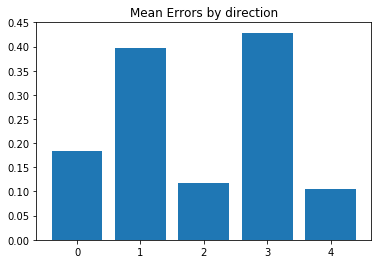

In [68]:
x = ['0','1','2','3','4']
plt.bar(x, height= [res_0/i_0, res_1/i_1, res_2/i_2, res_3/i_3, res_4/i_4])
plt.xticks(x, ['0','1','2','3','4']);
plt.title("Mean Errors by direction")

Text(0.5,1,'0 Errors')

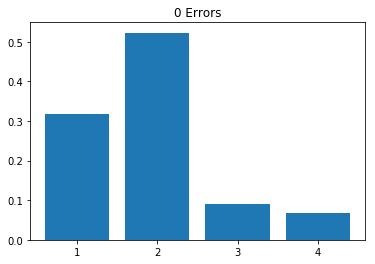

In [63]:
x = ['1','2','3','4']
plt.bar(x, height= [res_0_1/res_0, res_0_2/res_0, res_0_3/res_0, res_0_4/res_0])
plt.xticks(x, ['1','2','3','4']);
plt.title("0 Errors")

Text(0.5,1,'1 Errors')

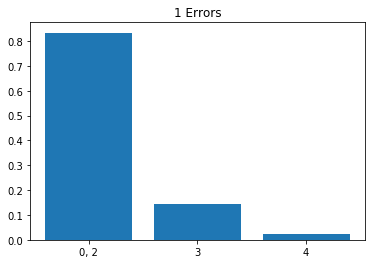

In [64]:
x = ['1','2','3']
plt.bar(x, height= [res_1_1/res_1, res_1_2/res_1, res_1_3/res_1])
plt.xticks(x, ['0, 2','3', '4']);
plt.title("1 Errors")

Text(0.5,1,'2 Errors')

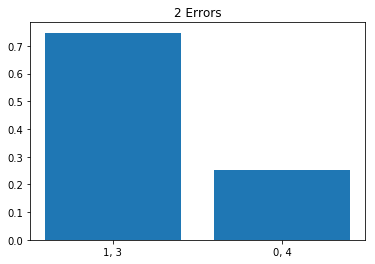

In [65]:
x = ['1','2']
plt.bar(x, height= [res_2_1/res_2, res_2_2/res_2])
plt.xticks(x, ['1, 3','0, 4']);
plt.title("2 Errors")

Text(0.5,1,'3 Errors')

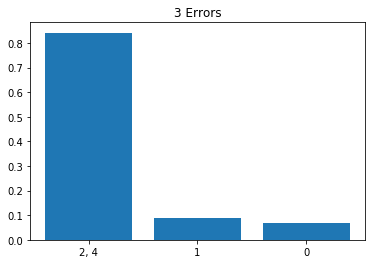

In [66]:
x = ['1','2','3']
plt.bar(x, height= [res_3_1/res_3, res_3_2/res_3, res_3_3/res_3])
plt.xticks(x, ['2, 4','1', '0']);
plt.title("3 Errors")

Text(0.5,1,'4 Errors')

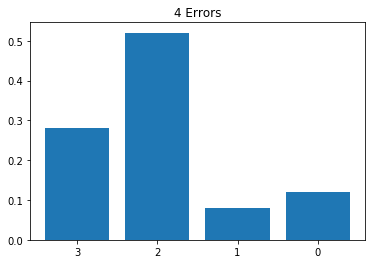

In [67]:
x = ['1','2','3','4']
plt.bar(x, height= [res_4_1/res_4, res_4_2/res_4, res_4_3/res_4, res_4_4/res_4])
plt.xticks(x, ['3','2','1','0']);
plt.title("4 Errors")